## Error, interpolation and projection

In [44]:
## Importing libraries

from dolfin import *
from mshr import *
import numpy
from datetime import datetime
import csv
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

### User defined parameters
#### Set the following parameters according to your problem

In [45]:
space_dim = 2

Lx = 1.0
Ly = 1.0

fileio = 'pvd'
dir_ = './results'

if not os.path.exists(dir_):
    os.mkdir(dir_)

if(space_dim == 2):
   domain = Rectangle(Point(0.0,0.0), Point(Lx,Ly))
else:
   sys.exit("space_dim.eq.3 not implemented")

# Thermal conductivity
k = 1.0
kappa = Constant(k)

# Use quadrilateral elements?
Qk = False


### Set the problem and solve it, recording relevant info

In [46]:
# For remembering relevant info
elapsed_time  = []
errorsH1      = []
errorsL2      = []
errors_interp = []

# Order of finite elements space
orders = [1,2,3]
mesh_refinements = [40,80,160]

for io, order in enumerate(orders):
    elapsed_time.append([])
    errorsH1.append([])
    errorsL2.append([])
    errors_interp.append([])
    for im, mesh_refinement in enumerate(mesh_refinements):
        if Qk:
            Pk = FiniteElement("Lagrange", 'quadrilateral', order)
        else:
            Pk = FiniteElement("Lagrange", 'triangle', order)

        #### IO setup
        ufile_pvd  = File(dir_+f'/temperatureO{order}mr{mesh_refinement}.pvd')
        domfile_pvd = File(dir_+f"/auxfuncO{order}mr{mesh_refinement}.pvd")

        startTime = datetime.now()
        print(f'\n   ::> Begin computations for order {order} and refinement {mesh_refinement}')


        #### Mesh generation
        if Qk:
            mesh = UnitSquareMesh.create(mesh_refinement, 
                                         mesh_refinement, 
                                         CellType.Type.quadrilateral)
        else:
            mesh = generate_mesh(domain, mesh_refinement)

        #print("    |-Mesh done")
        print("    |--Number of vertices = "+str(mesh.num_vertices()))
        #print("    |--Number of cells = "+str(mesh.num_cells()))
        #print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))


        # Finite element space
        W = FunctionSpace(mesh, Pk)
        print("    |--Total number of unknowns = %d" % (W.dim()))

        ### Variational formulation: Poisson problem
        u = TrialFunction(W)
        v = TestFunction(W)

        funcdom = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
        dx = Measure("dx")(subdomain_data=funcdom)
        #dx = Measure("dx")

        # Volumetric source
        f = Expression("8*pow(pi,2)*cos(2*pi*x[0])*cos(2*pi*x[1])", degree = 5)

        a = inner(kappa*grad(u), grad(v))*dx
        L = f*v*dx

        #### Dirichlet boundary conditions on W
        Tboundary = Expression("cos(2*pi*x[0])*cos(2*pi*x[1])", degree = 5)
        bcs = DirichletBC(W, Tboundary, DomainBoundary())


        ### Solution
        w = Function(W)

        # For Mesh refinement
        # problem = LinearVariationalProblem(a, L, w, bcs)
        # solver = LinearVariationalSolver(problem)
        # prm = solver.parameters
        # linear_solver = 'Krylov'
        # if linear_solver == 'Krylov':
        #     prm ["linear_solver"]= "gmres"
        #     prm ["preconditioner"]= "ilu"
        #     prm ["krylov_solver"]["absolute_tolerance"]= 1e-11
        #     prm ["krylov_solver"]["relative_tolerance"]= 1e-10
        #     prm ["krylov_solver"]["maximum_iterations"]= 10000
        #     prm ["krylov_solver"]["monitor_convergence"]= True
        #     prm ["krylov_solver"]["nonzero_initial_guess"]= True
        # else :
        #     prm ["linear_solver"]= "mumps"

        # solver.solve()
        solve(a == L, w, bcs)
        #      solver_parameters={'linear_solver':'gmres', 'preconditioner':'ilu'})

        ####### IO
        ufile_pvd << w
        domfile_pvd << funcdom

        elapsed_time[io].append(datetime.now() - startTime)
        print('\n  ::> Elapsed time: ', str(elapsed_time[io][im]), '\n')


        # plt.figure(figsize=(15,15))
        # plot(mesh,linewidth=.2)
        # c = plot(w, wireframe=True, title=f'Solution')
        # plt.colorbar(c)
        # plt.show()

        #### Compute errors
        uexact = Expression('cos(2*pi*x[0])*cos(2*pi*x[1])', degree = 7)
        errorsH1[io].append(errornorm(uexact, w, 'H1'))
        errorsL2[io].append(errornorm(uexact, w, 'L2'))


        # Interpolate exact solution and compute interpolation error
        Pk = FiniteElement("Lagrange", 'triangle', order)
        W = FunctionSpace (mesh, Pk)

        uinter = interpolate (uexact , W)
        errors_interp[io].append(errornorm(uexact, w, 'H1'))


   ::> Begin computations for order 1 and refinement 40
    |--Number of vertices = 2521
    |--Total number of unknowns = 2521

  ::> Elapsed time:  0:00:00.318301 


   ::> Begin computations for order 1 and refinement 80
    |--Number of vertices = 10024
    |--Total number of unknowns = 10024

  ::> Elapsed time:  0:00:00.842215 


   ::> Begin computations for order 1 and refinement 160
    |--Number of vertices = 39879
    |--Total number of unknowns = 39879

  ::> Elapsed time:  0:00:03.616536 


   ::> Begin computations for order 2 and refinement 40
    |--Number of vertices = 2521
    |--Total number of unknowns = 9904

  ::> Elapsed time:  0:00:00.445009 


   ::> Begin computations for order 2 and refinement 80
    |--Number of vertices = 10024
    |--Total number of unknowns = 39759

  ::> Elapsed time:  0:00:02.211610 


   ::> Begin computations for order 2 and refinement 160
    |--Number of vertices = 39879
    |--Total number of unknowns = 158845

  ::> Elapsed time:

### Errors

In [51]:
elapsed_time_df = pd.DataFrame(data = [[time.microseconds for time in el] for el in elapsed_time],
                            columns = mesh_refinements,
                            index = [1,2,3])

errorsH1_df  = pd.DataFrame(data = errorsH1,
                            columns = mesh_refinements,
                            index = [1,2,3])


errorsL2_df  = pd.DataFrame(data = errorsL2,
                            columns = mesh_refinements,
                            index = [1,2,3])


errors_interp_df  = pd.DataFrame(data = errors_interp,
                                columns = mesh_refinements,
                                index = [1,2,3])

errorsH1_df

,40,80,160
1,0.239755,0.119542,0.059635
2,0.005779,0.001426,0.000357
3,0.000093,0.000012,0.000001


In [52]:
errorsL2_df

,40,80,160
1,1.781840e-03,4.534708e-04,1.126886e-04
2,1.858061e-05,2.281334e-06,2.835858e-07
3,2.240032e-07,1.388722e-08,8.508378e-10


In [53]:
errors_interp_df

,40,80,160
1,0.239755,0.119542,0.059635
2,0.005779,0.001426,0.000357
3,0.000093,0.000012,0.000001


### Solve for the circle

In [34]:
radius = 1
domain = Circle(Point(0,0), radius)
mesh_refinement = 10
order = 2
uexact = Expression("(1 - pow(x[0],2) - pow(x[1],2))/4", degree = 2)


Pk = FiniteElement("Lagrange", 'triangle', order)
mesh = generate_mesh(domain, mesh_refinement)


# Finite element space
W = FunctionSpace(mesh, Pk)


### Variational formulation: Poisson problem
u = TrialFunction(W)
v = TestFunction(W)

funcdom = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
dx = Measure("dx")(subdomain_data=funcdom)


# Volumetric source
f = Constant(1)

a = inner(kappa*grad(u), grad(v))*dx
L = f*v*dx

#### Dirichlet boundary conditions on W
bcs = DirichletBC(W, Constant(0), DomainBoundary())


### Solution
w1 = Function(W)

solve(a == L, w1, bcs)

print("\n With zeroed boundary condition")
print("| - Error L2 = ", errornorm(uexact, w1, 'L2'))
print("| - Error H1 = ", errornorm(uexact, w1, 'H1'))



# Fixed boundary conditions, using exact values
bcs = DirichletBC(W, uexact, DomainBoundary())

### Solution
w2 = Function(W)

solve(a == L, w2, bcs)

print("\n With true boundary condition")
print("| - Error L2 = ", errornorm(uexact, w2, 'L2'))
print("| - Error H1 = ", errornorm(uexact, w2, 'H1'))


#################################################
########## Solving the projection problem


alpha = 1
a = inner(u,v)*dx + alpha*inner(grad(u), grad(v))*dx
L = Constant(0)


 With zeroed boundary condition
| - Error L2 =  0.0031386615336167684
| - Error H1 =  0.01429785608784399

 With true boundary condition
| - Error L2 =  1.5887870261888376e-14
| - Error H1 =  4.8637438090804096e-14


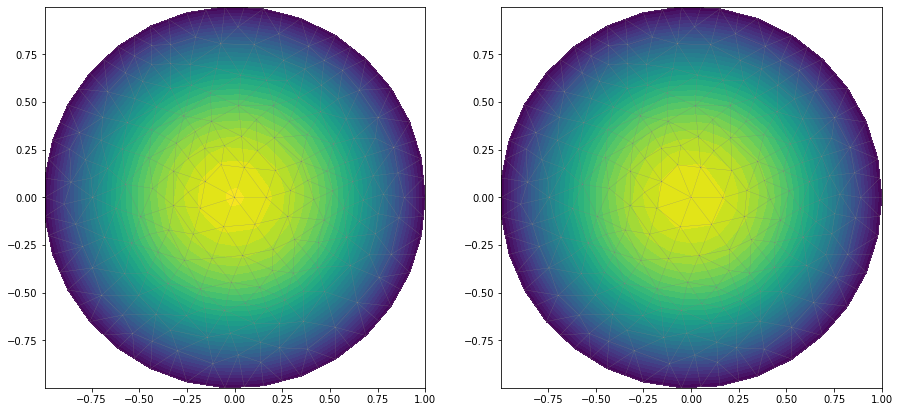

In [43]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plot(mesh, linewidth=.2)
plot(w2)

plt.subplot(122)
plot(mesh, linewidth=.2)
plot(w1)

### Bônus

In [ ]:

alpha = 1

# Define function spaces and mixed (product) space
V = FunctionSpace(mesh, "CG", 1)
R = FunctionSpace(mesh, "R", 0)
W = V * R

# Define variational problem
(u, l) = TrialFunction(W)
(v, d) = TestFunctions(W)
f = Expression("8*pow(pi,2)*cos(2*pi*x[0])*cos(2*pi*x[1])", degree = 5)
a = (inner(grad(u), grad(v)) + l*v)*dx
L = f*v*dx